# Model 1

XGB Boost Model

In [47]:
! pip install -r requirements.txt

In [16]:
#
# basics
import pandas as pd
import numpy as np

# plotting
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('white')
sns.set_palette('magma')
from sklearn.model_selection import train_test_split
import missingno as msno
from xgboost import XGBRegressor


# warnings
import warnings
warnings.filterwarnings('ignore')

RSEED = 42

# EDA

In [10]:
# load training data
df = pd.read_csv('data/Train.csv')

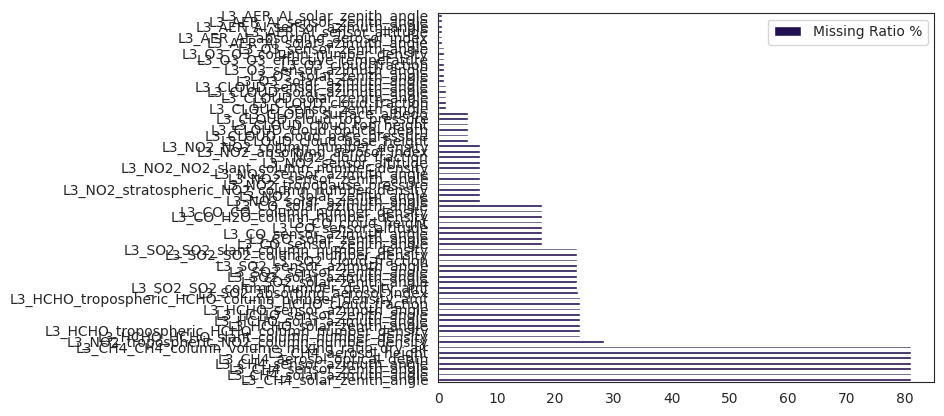

In [3]:
import matplotlib.pyplot as plt
def plot_nas(df: pd.DataFrame):
    if df.isnull().sum().sum() != 0:
        na_df = (df.isnull().sum() / len(df)) * 100      
        na_df = na_df.drop(na_df[na_df == 0].index).sort_values(ascending=False)
        missing_data = pd.DataFrame({'Missing Ratio %' :na_df})
        missing_data.plot(kind = "barh")
        plt.show()
    else:
        print('No NAs found')
plot_nas(df)
plot_width, plot_height = (15,15)
plt.rcParams['figure.figsize'] = (plot_width,plot_height)
plt.rcParams['ytick.labelsize'] = 9

In [11]:
# drop columns with more than 50% missing values
check_ch4 = [col for col in df.columns if 'CH4' in col]
df.drop(columns=check_ch4, axis=1, inplace=True)

# Convert to datetime
df["Date"] = pd.to_datetime(df["Date"])

# Create integer column for weekends
df["IsWeek"] = (df["Date"].dt.weekday < 5).astype(int)

df.drop(columns=['Date', 'Place_ID', 'Place_ID X Date', 'target_min', 'target_max', 'target_variance', 'target_count'], axis=1, inplace=True)

df.head(5)

,target,precipitable_water_entire_atmosphere,relative_humidity_2m_above_ground,specific_humidity_2m_above_ground,temperature_2m_above_ground,u_component_of_wind_10m_above_ground,v_component_of_wind_10m_above_ground,L3_NO2_NO2_column_number_density,L3_NO2_NO2_slant_column_number_density,L3_NO2_absorbing_aerosol_index,...,L3_SO2_SO2_column_number_density,L3_SO2_SO2_column_number_density_amf,L3_SO2_SO2_slant_column_number_density,L3_SO2_absorbing_aerosol_index,L3_SO2_cloud_fraction,L3_SO2_sensor_azimuth_angle,L3_SO2_sensor_zenith_angle,L3_SO2_solar_azimuth_angle,L3_SO2_solar_zenith_angle,IsWeek
0,38.0,11.000000,60.200001,0.00804,18.516840,1.996377,-1.227395,0.000074,0.000156,-1.231330,...,-0.000127,0.312521,-0.000040,-1.861476,0.000000,76.536426,38.593017,-61.752587,22.363665,1
1,39.0,14.600000,48.799999,0.00839,22.546533,3.330430,-1.188108,0.000076,0.000197,-1.082553,...,0.000150,0.433957,0.000050,-1.452612,0.059433,-14.708036,59.624912,-67.693509,28.614804,1
2,24.0,16.400000,33.400002,0.00750,27.031030,5.065727,3.500559,0.000067,0.000170,-1.001242,...,0.000150,0.356925,0.000053,-1.572950,0.082063,-105.201338,49.839714,-78.342701,34.296977,0
3,49.0,6.911948,21.300001,0.00391,23.971857,3.004001,1.099468,0.000083,0.000175,-0.777019,...,0.000227,0.584522,0.000110,-1.239317,0.121261,-104.334066,29.181258,-73.896588,30.545446,0
4,21.0,13.900001,44.700001,0.00535,16.816309,2.621787,2.670559,0.000070,0.000142,0.366323,...,0.000390,0.408047,0.000159,0.202489,0.037919,58.850179,0.797294,-68.612480,26.899694,1


<Axes: >

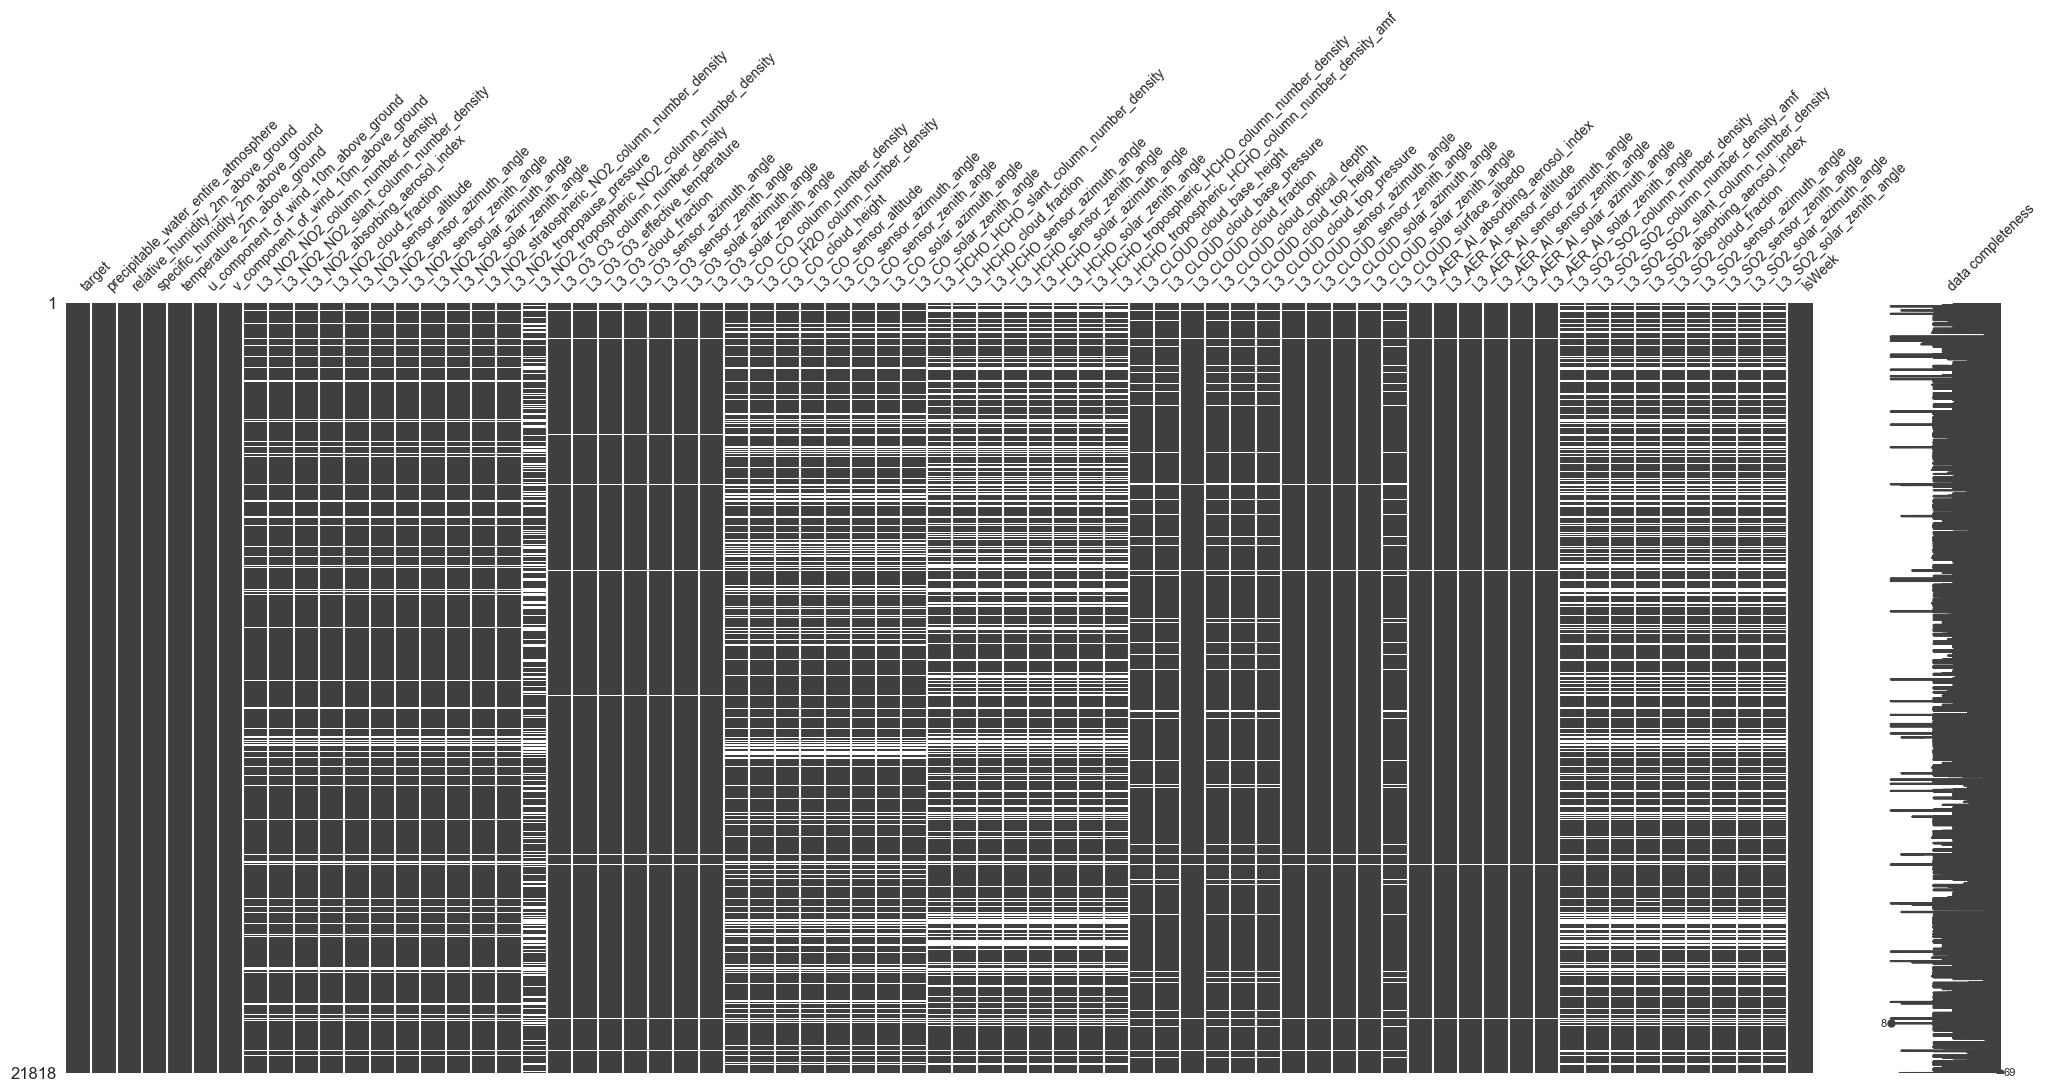

In [58]:
msno.matrix(df.query('IsWeek == 1'), fontsize=10,labels=True)

<Axes: >

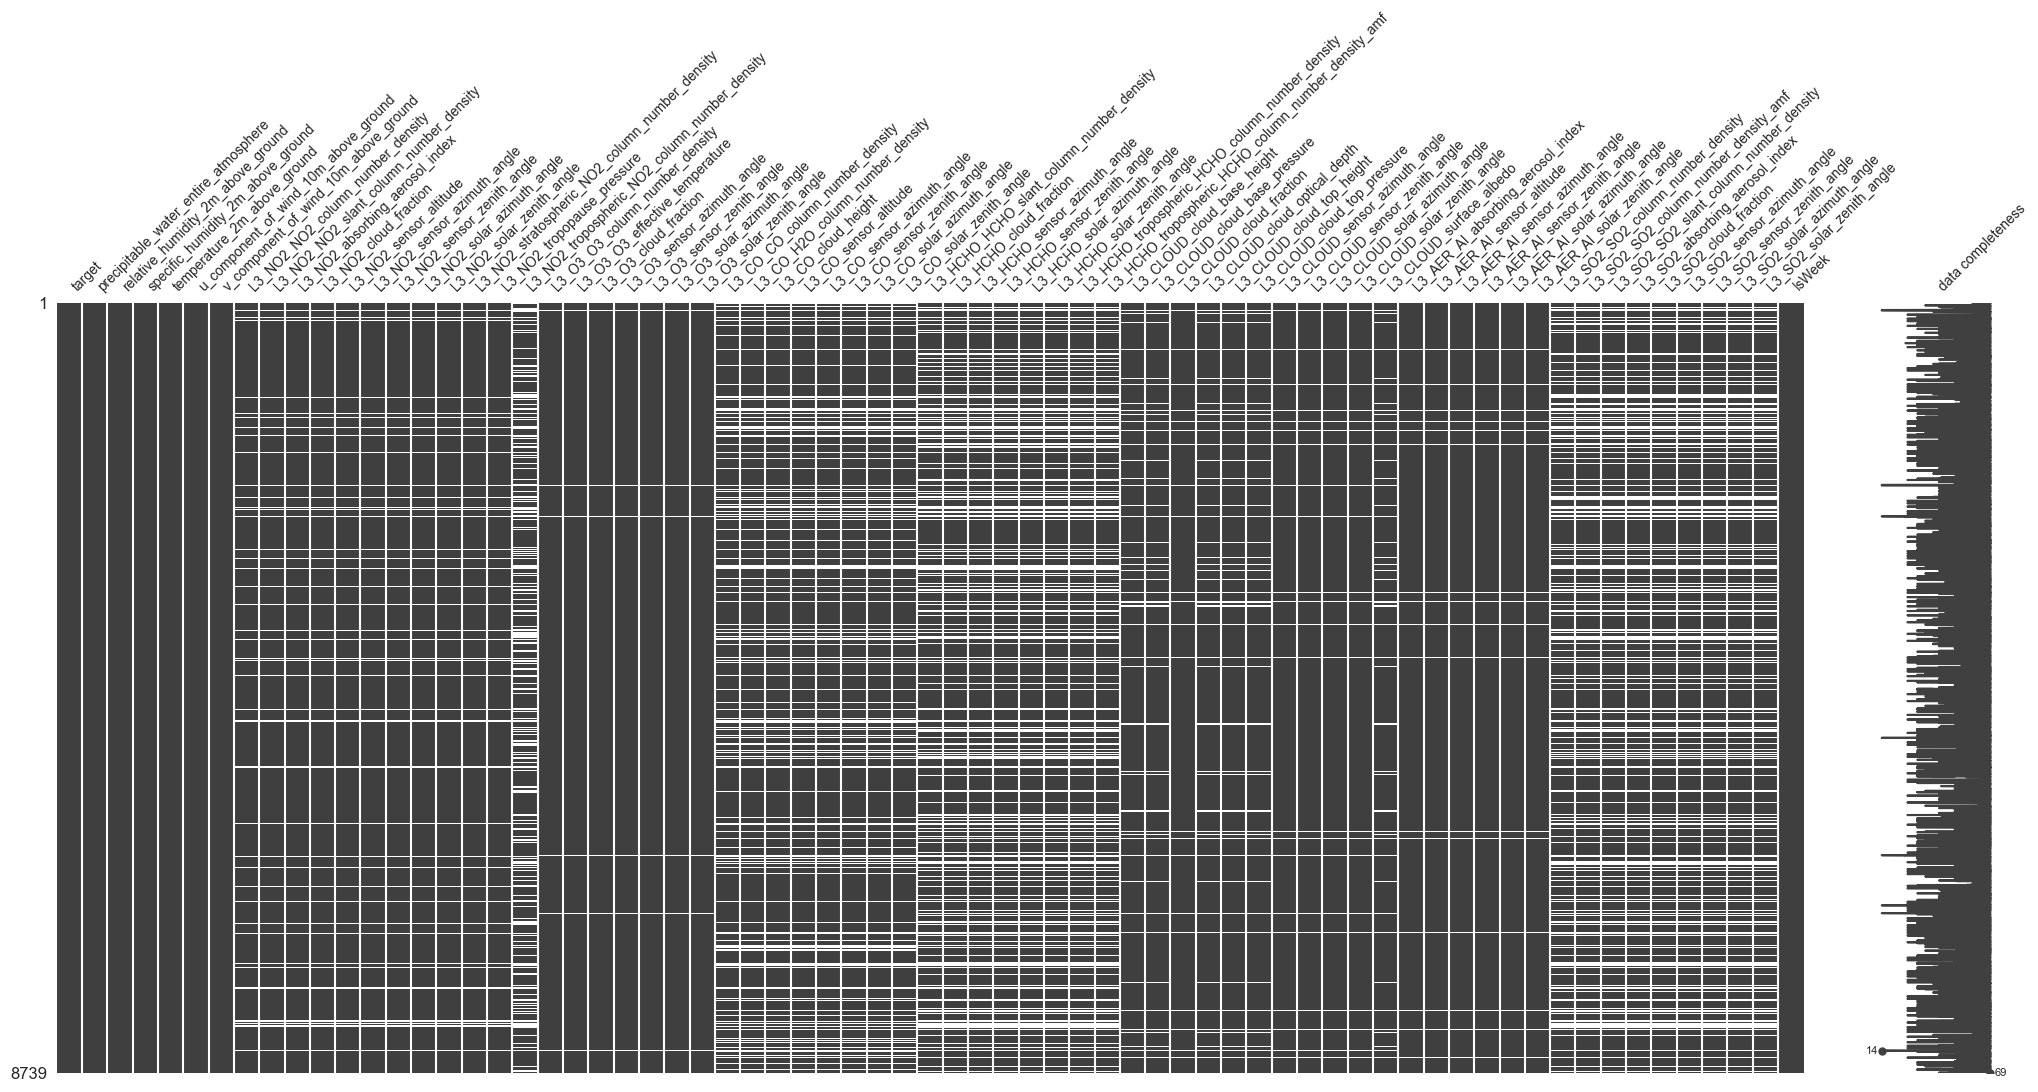

In [59]:
msno.matrix(df.query('IsWeek == 0'), fontsize=10,labels=True)

In [12]:
#removes 0 as outliers
variables_list_0_as_outlier = [
    "L3_NO2_NO2_column_number_density",
    "L3_NO2_NO2_slant_column_number_density",
    "L3_NO2_sensor_altitude",
    "L3_NO2_tropopause_pressure",
    "L3_NO2_solar_zenith_angle",
    "L3_SO2_SO2_column_number_density",
    "L3_SO2_SO2_column_number_density_amf",
    "L3_SO2_SO2_slant_column_number_density",
    "L3_SO2_solar_zenith_angle",
    "L3_O3_O3_column_number_density",
    "L3_O3_O3_effective_temperature",
    "L3_O3_solar_zenith_angle",
    "L3_CO_CO_column_number_density",
    "L3_CO_sensor_altitude",
    "L3_CO_solar_zenith_angle",
    "L3_HCHO_solar_zenith_angle",
    "L3_HCHO_tropospheric_HCHO_column_number_density_amf"
]

df[variables_list_0_as_outlier].replace(0, np.nan, inplace=True)

<Axes: >

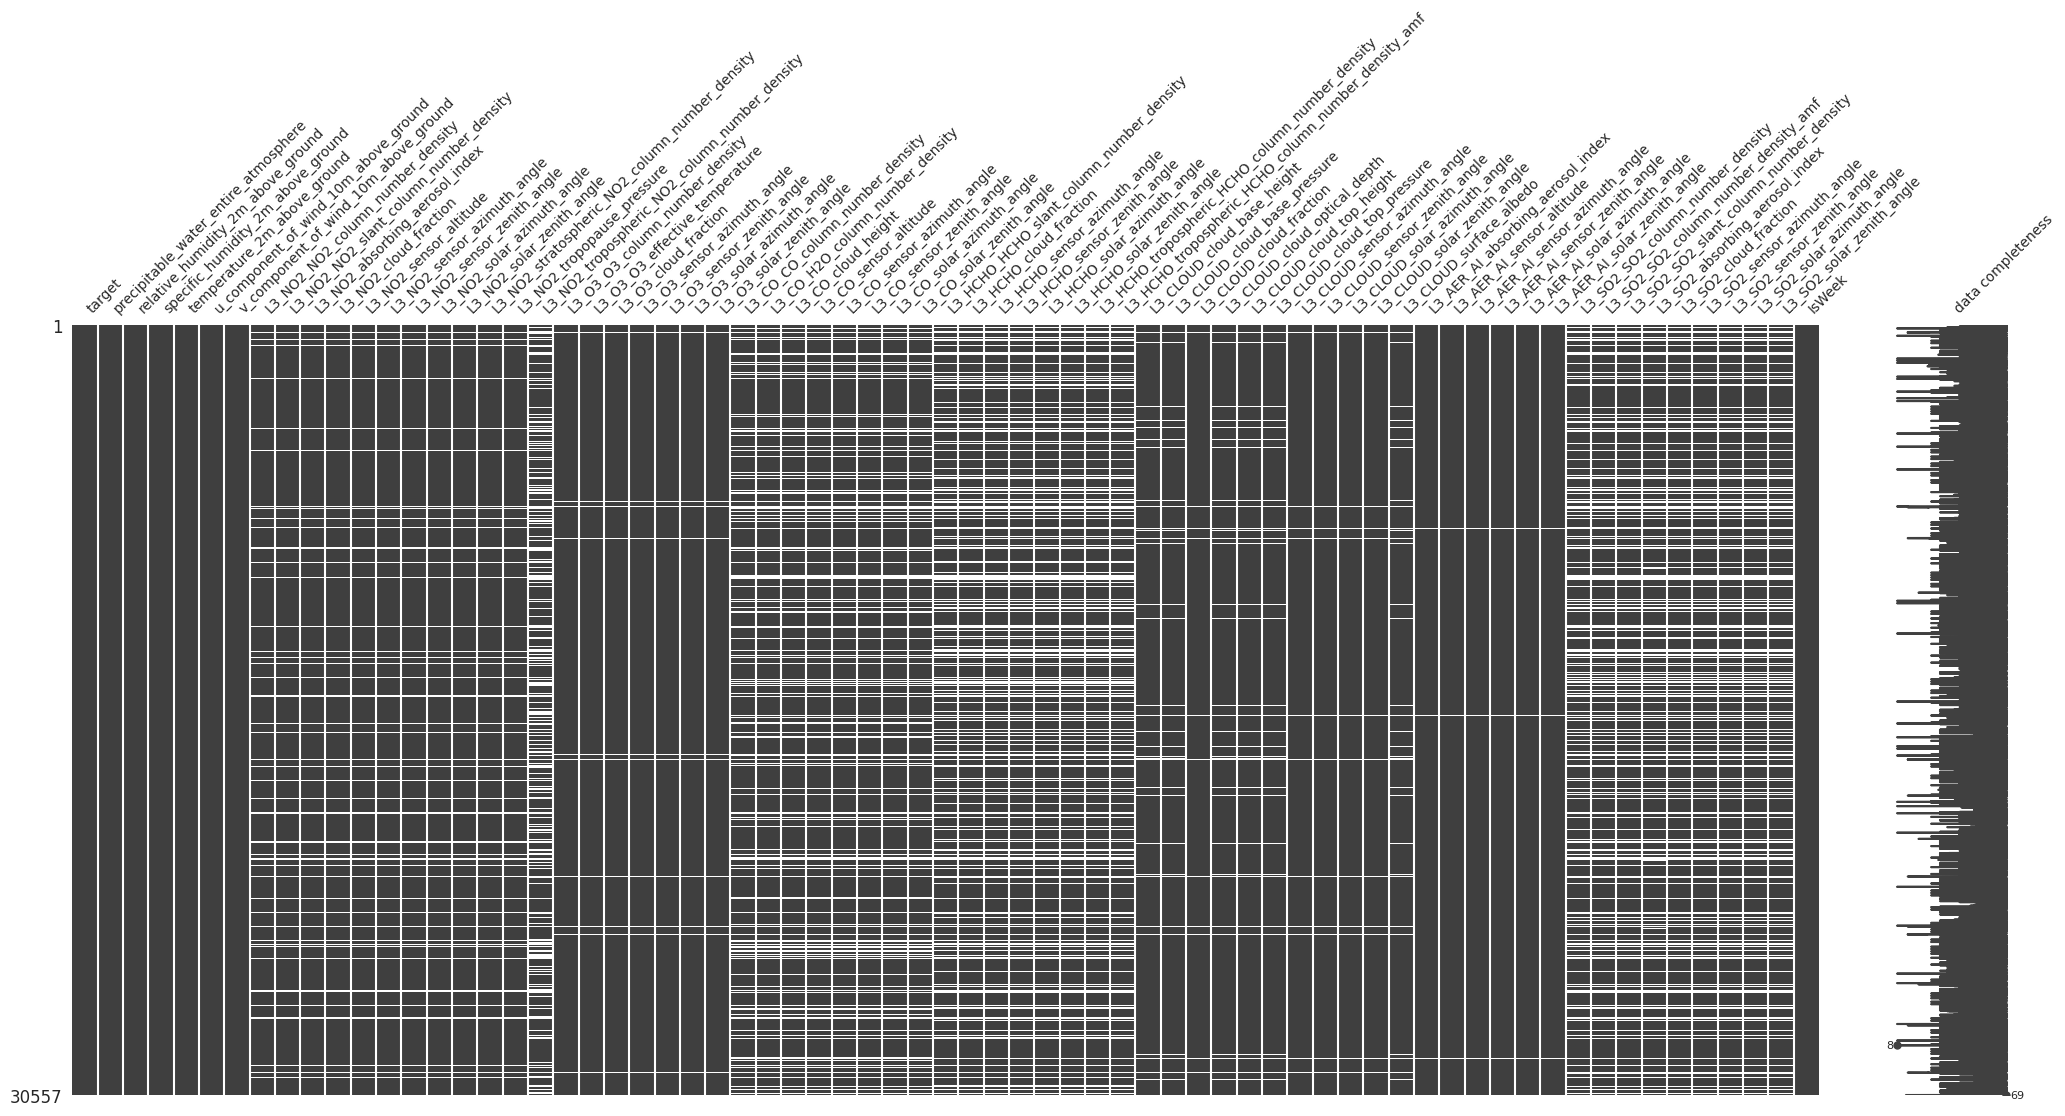

In [15]:
msno.matrix(df, fontsize=10,labels=True)

In [17]:
X = df.drop("target", axis=1)
y = df.target

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RSEED)

In [ ]:
# Pipeline XGBoost Regression

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import  StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
import xgboost as xgb

features = list(X.columns)

num_pipeline = Pipeline([
    ('imputer_num', SimpleImputer(strategy='median')),
    ('std_scaler', StandardScaler())
])

preprocessor = ColumnTransformer([
    ('num', num_pipeline, features),
])

pipe_xgbreg = Pipeline([
    ('preprocessor', preprocessor),
    ('xgbreg', xgb.XGBRegressor(eta = 0.05))  # only parameter that is fixed for everything, not hyperparameter to try later
])



In [19]:
pipe_xgbreg

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer_num',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('std_scaler',
                                                                   StandardScaler())]),
                                                  ['precipitable_water_entire_atmosphere',
                                                   'relative_humidity_2m_above_ground',
                                                   'specific_humidity_2m_above_ground',
                                                   'temperature_2m_above_ground',
                                                   'u_component_of_wind_10m_above_ground'...
                              eval_metric=None, feature_types=None, gamma=None,
                              gpu_id=None, grow_policy=None,
                              importance_type=None,
                              interaction_constraints=None, learning_rate=None,
                              max_bin=None, max_cat_threshold=None,
                              max_cat_to_onehot=None, max_delta_step=None,
                              max_depth=None, max_leaves=None,
                              min_child_weight=None, missing=nan,
                              monotone_constraints=None, n_estimators=100,
                              n_jobs=None, num_parallel_tree=None,
                              predictor=None, ...))])

-- clened until here :D 

In [72]:
from sklearn.model_selection import cross_val_predict

xgb.cv(
    params=pipe_xgbreg.get_params()['xgbreg'].get_xgb_params(),
    dtrain=xgb.DMatrix(X_train, y_train),
    num_boost_round=20,
    nfold=5,
    metrics='mape',
    seed=RSEED
)

y_train_predicted = cross_val_predict(pipe_xgbreg, X_train, y_train, cv=5) 
#y_test_predicted = cross_val_predict(pipe_xgbreg, X_test, y_test, cv=5) 

In [73]:
#y_train = pd.DataFrame(y_train)  

In [74]:
y_train.shape, y_test.shape, X_train.shape, X_test.shape

((24445,), (6112,), (24445, 68), (6112, 68))

In [102]:
param_xgbreg = {'xgbreg__n_estimators': [10, 50],
         'xgbreg__learning_rate': [0.01, 0.05, 0.1], 
         'xgbreg__max_depth': [3, 5, 7],
        'xgbreg__colsample_bytree': [0.2, 0.6],
        'xgbreg__gamma': [0, 0.1, 0.2],
        'xgbreg__scale_pos_weight': [1],
            }


In [100]:
y_train.shape, y_test.shape, X_train.shape, X_test.shape

((24445,), (6112,), (24445, 68), (6112, 68))

In [103]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_absolute_error

from sklearn.metrics import make_scorer, mean_absolute_percentage_error


In [104]:
from sklearn.model_selection import GridSearchCV

grid_xbreg = GridSearchCV(pipe_xgbreg, param_grid=param_xgbreg, cv=5, scoring='neg_mean_absolute_error', 
                           verbose=5, n_jobs=-1)

grid_xbreg.fit(X_train, y_train)

grid_xbreg.best_params_

Fitting 5 folds for each of 108 candidates, totalling 540 fits


[CV 3/5] END xgbreg__colsample_bytree=0.2, xgbreg__gamma=0, xgbreg__learning_rate=0.01, xgbreg__max_depth=3, xgbreg__n_estimators=10, xgbreg__scale_pos_weight=1;, score=-54.581 total time=   2.1s
[CV 1/5] END xgbreg__colsample_bytree=0.2, xgbreg__gamma=0, xgbreg__learning_rate=0.01, xgbreg__max_depth=3, xgbreg__n_estimators=10, xgbreg__scale_pos_weight=1;, score=-54.593 total time=   2.0s
[CV 2/5] END xgbreg__colsample_bytree=0.2, xgbreg__gamma=0, xgbreg__learning_rate=0.01, xgbreg__max_depth=3, xgbreg__n_estimators=10, xgbreg__scale_pos_weight=1;, score=-54.017 total time=   2.1s
[CV 5/5] END xgbreg__colsample_bytree=0.2, xgbreg__gamma=0, xgbreg__learning_rate=0.01, xgbreg__max_depth=3, xgbreg__n_estimators=10, xgbreg__scale_pos_weight=1;, score=-55.950 total time=   2.1s
[CV 4/5] END xgbreg__colsample_bytree=0.2, xgbreg__gamma=0, xgbreg__learning_rate=0.01, xgbreg__max_depth=3, xgbreg__n_estimators=10, xgbreg__scale_pos_weight=1;, score=-55.431 total time=   2.1s
[CV 1/5] END xgbreg_

{'xgbreg__colsample_bytree': 0.6,
 'xgbreg__gamma': 0.2,
 'xgbreg__learning_rate': 0.1,
 'xgbreg__max_depth': 7,
 'xgbreg__n_estimators': 50,
 'xgbreg__scale_pos_weight': 1}

In [106]:
grid_xbreg.best_params_, grid_xbreg.best_score_

({'xgbreg__colsample_bytree': 0.6,
  'xgbreg__gamma': 0.2,
  'xgbreg__learning_rate': 0.1,
  'xgbreg__max_depth': 7,
  'xgbreg__n_estimators': 50,
  'xgbreg__scale_pos_weight': 1},
 -21.13136780249802)

In [107]:
best_model = grid_xbreg.best_estimator_


In [ ]:
y_test_predicted = best_model.predict(X_test)

array([ 60.225494,  54.632538,  16.870306, ..., 102.87512 ,  62.035046,
        31.479458], dtype=float32)

In [117]:

print("mean_absolute_error: {:.2f}".format(mean_absolute_error(y_test, y_test_predicted)))



mean_absolute_error: 21.09


In [79]:
dtrain = xgb.DMatrix(X_train, label=y_train)

In [86]:
mape_scorer = make_scorer(mean_absolute_percentage_error, greater_is_better=False)

In [91]:

rs = RandomizedSearchCV(
    estimator=pipe_xgbreg,
    param_distributions=param_xgbreg,
    n_iter=100,
    scoring='neg_mean_absolute_error',
    cv=3,
    verbose=1,
    n_jobs=-1,
    random_state=RSEED
)

rs.fit(X_train, y_train)
rs.best_score_


Fitting 3 folds for each of 24 candidates, totalling 72 fits


-38.305119328660446

In [ ]:
type(X_train), type(y_train)
y_train = pd.DataFrame(y_train)  

In [ ]:
# Defining parameter space for grid-search. Since we want to access the classifier step (called 'logreg') in our pipeline 
# we have to add 'logreg__' in front of the corresponding hyperparameters. 
param_ = {'logreg__penalty':('l1','l2'),
                'logreg__C': [0.001, 0.01, 0.1, 1, 10],
                'logreg__solver': ['liblinear', 'lbfgs', 'sag']
               }

grid_logreg = GridSearchCV(pipe_logreg, param_grid=param_logreg, cv=5, scoring='accuracy', 
                           verbose=5, n_jobs=-1)